# Predict Home Price - Fine-Tune Base Model 

### *Introduction*  
The goal of this project is to makes predictions about the future sale prices of homes. The prediction results are evaluated on **Mean Absolute Error** between the predicted log error and the actual log error. The logerror (target variable) is defined as ***logerror=log(Zestimate)−log(SalePrice)*** and is recorded in the training data. 

In the previous notebooks, the data which contains the list of real estate properties in three counties (Los Angeles, Orange and Ventura, California) data in 2016 were analyzed and cleaned. Base models were built and optimized using the cleaned dataset. 

### *About This Notebook*
This notebook experiments with **model stacking** using the previously optimized models (Ridge, KNeighborsRegressor, RandomForestRegressor, and GradientBoostingRegressor). 

***In the first level of prediction***   
a. The 4 models are used to train *(k-1)* (*k*: number of folds) folds of train set and predict the out-of-fold train set to result in a new train set containing the predictions of the 4 models as new features.     
b. Similarly, each model trained on the *(k-1)* folds of train set is used to predict the entire test set, leading to *k* results which are averaged to obtained a mean prediction for each model. The predictions of the 4 models thus result in a new test set with 4 new features.    

***In the first level of prediction,***   
a. The new train set (with the original train labels) is used train a XGBoost model.   
b. The trained model is used to predict the new test set to obtain the final result.   
 
The mean absolute error of prediction on test set is:
- 0.06708028229370397

***Next Step:***  
Try different combinations of base models for stacking.

## 0 | Package and Configuration

In [22]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
sns.set_style('white')
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

In [2]:
# initiate random seed
SEED = 8

In [3]:
# hide warnings
import warnings
warnings.filterwarnings('ignore')

## 1 | Data Preparation

### 1.1 Get Data

In [4]:
DATA_PATH = '../data'

def load_data(path, file_name):
    """load csv data and return dataframe"""
    csv_path = os.path.join(path, file_name)
    return pd.read_csv(csv_path)

In [7]:
# load train_merge.csv - created in Notebook1
train_merge = load_data(DATA_PATH, file_name='train_merge.csv')
# drop `transactiondate` and `parcelid` in train
train_merge.drop(['transactiondate', 'parcelid'], axis=1, inplace=True)

In [8]:
# load prop_downsized.csv - created in Notebook1
prop = load_data(DATA_PATH, file_name='prop_downsized.csv')
# drop `parcelid` in prop
prop.drop(['parcelid'], axis=1, inplace=True)

In [10]:
# set aside a test set
train_set, test_set = train_test_split(train_merge, test_size=0.2, random_state=SEED)
print('Training set size: {}\nTest set size: {}'.format(train_set.shape, test_set.shape))

Training set size: (72220, 58)
Test set size: (18055, 58)


In [11]:
# remove outliers
train_wo_outlier = train_set[(train_set.logerror > -0.4) & (train_set.logerror < 0.42)]
train_w_outlier = train_set.copy()

In [19]:
y_train = train_wo_outlier['logerror'].values
X_train = train_wo_outlier.drop(['logerror'], axis=1)

### 1.2 Preprocess data

In [39]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    """select desired features and drop the rest"""
    def __init__(self, features):
        self.features = features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.features]

In [40]:
class FeatureAdder(BaseEstimator, TransformerMixin):
    """add new features including average size of rooms, ratio between living area and lot size,
    ratio between property tax and total tax, and ratio between structure value and land value"""
    def __init__(self, add_new_feature=True):
        self.add_new_feature = add_new_feature
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # define new features
        N_AvgSize = X['calculatedfinishedsquarefeet']/(X['bedroomcnt'] + X['bathroomcnt'] + 1)
        N_PropLot = X['calculatedfinishedsquarefeet']/X['lotsizesquarefeet']
        N_ValueRatio = X['taxamount']/X['taxvaluedollarcnt']
        N_StructLand = X['structuretaxvaluedollarcnt']/X['landtaxvaluedollarcnt']
        # add new features if True
        if self.add_new_feature:
            return np.c_[X, N_AvgSize, N_PropLot, N_ValueRatio, N_StructLand]
        else:
            return X

In [41]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    """drop features with percentage of missing missing values larger than missing_pct"""
    def __init__(self, missing_pct=1, drop_cols=[]):
        self.missing_pct = missing_pct # missing value percentage threshold
        self.drop_cols = drop_cols # initialize columns to drop
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for col in X.columns:
            if pd.isnull(X[col]).sum()/X.shape[0] >= self.missing_pct:
                self.drop_cols.append(col)
        X = X.drop(self.drop_cols, axis=1)
        return X

In [42]:
class CatTransformer(BaseEstimator, TransformerMixin):
    """categorival feature transformer: impute categorical value and encode categories"""
    def __init__(self, cat_dict):
        self.cat_dict = cat_dict
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for col in X.columns:
            if X[col].dtype == 'O':
                X[col].fillna('-99', inplace=True)
            X[col].fillna(-99, inplace=True)
            X[col] = X[col].astype('category', categories=self.cat_dict[col])
        return X

In [43]:
class DummyEncoder(TransformerMixin):
    """create dummy variables"""
    def __init__(self, columns=None):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return pd.get_dummies(X, columns=self.columns)

In [44]:
# numerical features
num_features = ['basementsqft', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', \
             'threequarterbathnbr', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',\
             'finishedsquarefeet6', 'finishedsquarefeet12', 'finishedsquarefeet13', \
             'finishedsquarefeet15', 'finishedsquarefeet50', 'fireplacecnt', 'fullbathcnt', \
             'garagecarcnt', 'garagetotalsqft', 'latitude', 'longitude', 'lotsizesquarefeet', \
             'numberofstories', 'poolcnt', 'poolsizesum', 'roomcnt', \
             'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt', \
             'taxvaluedollarcnt', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', \
             'taxamount', 'assessmentyear']

# categorical features
cat_features = ['airconditioningtypeid', 'decktypeid', 'architecturalstyletypeid', \
               'buildingclasstypeid', 'heatingorsystemtypeid', 'fips', 'fireplaceflag', \
               'hashottuborspa', 'pooltypeid10', 'pooltypeid2', 'propertylandusetypeid', \
               'propertyzoningdesc', 'regionidcounty', 'taxdelinquencyflag', 'propertycountylandusecode', \
                'rawcensustractandblock', 'censustractandblock', 'regionidcity', 'regionidzip', \
                'regionidneighborhood', 'storytypeid', 'pooltypeid7', 'typeconstructiontypeid', 'taxdelinquencyyear']

# potential features to drop (categorical variables with large number of levels) 
drop_features = ['propertycountylandusecode', 'rawcensustractandblock', 'censustractandblock', \
                 'regionidcity', 'regionidzip', 'regionidneighborhood', 'propertyzoningdesc']

In [47]:
with open('../data/categories.pickle', 'rb') as handle:
    categories = pickle.load(handle)

In [48]:
# pipeline for numerical features
num_pipe = Pipeline([
        ('selector', DataFrameSelector(num_features)),
        ('feature_dropper', FeatureDropper(missing_pct=0.95)),
        ('feature_adder', FeatureAdder(add_new_feature=True)),
        ('imputer', Imputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

In [49]:
# pipeline for categorical features
cat_pipe = Pipeline([
        ('selector', DataFrameSelector(cat_features)), 
        ('feature_dropper', FeatureDropper(missing_pct=0.95, drop_cols=drop_features)),
        ('cat_transform', CatTransformer(categories)),
        ('get_dummy', DummyEncoder())
    ])

In [50]:
# full pipeline combining pipelines for numerical and categorical features
full_pipe = FeatureUnion([
        ('num_pipeline', num_pipe),
        ('cat_pipeline', cat_pipe)
    ])

In [51]:
# transform features with full_pipe
X_train_transformed = full_pipe.fit_transform(X_train)

In [52]:
# test features and labels
y_test = test_set['logerror'].values
X_test = test_set.drop(['logerror'], axis=1)
X_test_transformed = full_pipe.transform(X_test)

## 2 | Model Stacking

### 2.1 First level 

In [38]:
# initiate parameters
ntrain = X_train_transformed.shape[0]
ntest = X_test_transformed.shape[0]
NFOLDS = 5
kfold = KFold(n_splits= NFOLDS, shuffle=True, random_state=SEED)

In [39]:
class SklearnHelper(object):
    """extend the Sklearn method (fit, predict) to all classifiers"""
    def __init__(self, model, params=None):
        self.model = model(**params)

    def fit(self, X, y):
        return self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

In [55]:
def get_oof(model, X_train, y_train, X_test):
    """get out-of-fold prediction"""
    
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    # fit model with NFOLDS-1 folds and test on left-out fold as well sa test set
    for i, (train_index, test_index) in enumerate(kfold.split(X_train)):
        X_tr = X_train[train_index]
        y_tr = y_train[train_index]
        X_te = X_train[test_index]

        model.fit(X_tr, y_tr)

        oof_train[test_index] = model.predict(X_te)
        oof_test_skf[i, :] = model.predict(X_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [45]:
# parameters for the base models
ridge_params = {
    'alpha': 4000,
    'random_state': SEED
}

knn_params = {
    'n_jobs': -1,
    'n_neighbors': 80,
    'p': 1
}

rf_params = {
    'n_jobs': -1,
    'n_estimators': 500, 
    'max_depth': 5,
    'random_state': SEED
}

gb_params = {
    'n_estimators': 80, 
    'max_depth': 3,
    'random_state': SEED
}   

In [46]:
# Create objects of the models
ridge = SklearnHelper(model=Ridge, params=ridge_params)
knn = SklearnHelper(model=KNeighborsRegressor, params=knn_params)
rf = SklearnHelper(model=RandomForestRegressor, params=rf_params)
gb = SklearnHelper(model=GradientBoostingRegressor, params=gb_params)

In [56]:
# OOF train and test predictions
ridge_oof_train, ridge_oof_test = get_oof(ridge, X_train_transformed, 
                                          y_train, X_test_transformed)
knn_oof_train, knn_oof_test = get_oof(knn, X_train_transformed, 
                                      y_train, X_test_transformed)
rf_oof_train, rf_oof_test = get_oof(rf, X_train_transformed, 
                                    y_train, X_test_transformed) 
gb_oof_train, gb_oof_test = get_oof(gb, X_train_transformed, 
                                    y_train, X_test_transformed)

In [59]:
# 2nd level prediction with the first level output
base_pred_train = pd.DataFrame({
        'ridge': ridge_oof_train.ravel(),
        'knn': knn_oof_train.ravel(),
        'rf': rf_oof_train.ravel(),
        'gb': gb_oof_train.ravel()
    })
base_pred_train.head()

,gb,knn,rf,ridge
0,0.004632,-0.006104,0.004802,0.005834
1,-0.007503,-0.007574,0.004621,-0.003053
2,0.010662,0.006564,0.008791,0.009916
3,0.014528,-0.003636,0.008900,0.003424
4,-0.015111,-0.016555,-0.022401,-0.001636


In [65]:
base_pred_test = pd.DataFrame({
        'ridge': ridge_oof_test.ravel(),
        'knn': knn_oof_test.ravel(),
        'rf': rf_oof_test.ravel(),
        'gb': gb_oof_test.ravel()
    })

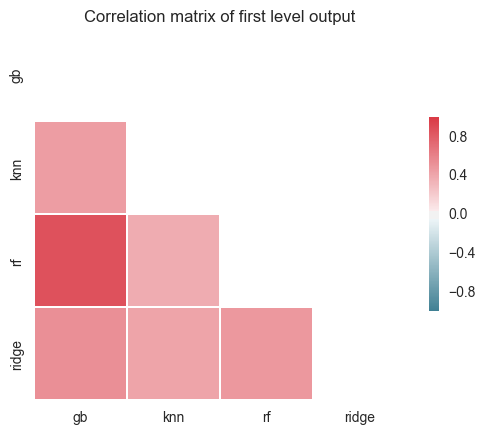

In [63]:
# correlation of first level output
corr = base_pred_train.corr()

# plot correlation matrix
f, ax = plt.subplots(figsize=(6, 5))
mask = np.zeros_like(corr, dtype=np.bool) # Generate a mask for the upper triangle
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation matrix of first level output');

In [62]:
corr

,gb,knn,rf,ridge
gb,1.000000,0.455252,0.871209,0.534937
knn,0.455252,1.000000,0.377244,0.422510
rf,0.871209,0.377244,1.000000,0.484763
ridge,0.534937,0.422510,0.484763,1.000000


The 4 models show some correlation with each other, especially between RandomForest and GradientBoosting.

In [66]:
# save base_pred_train and base_pred_test
base_pred_train.to_csv('../data/base_pred_train.csv', index=False)
base_pred_test.to_csv('../data/base_pred_test.csv', index=False)

### 2.2 Second Level

In [67]:
# predictions from first level output as the new train and test set
X_train_2 = np.concatenate((ridge_oof_train, knn_oof_train, rf_oof_train, gb_oof_train), axis=1)
X_test_2 = np.concatenate((ridge_oof_test, knn_oof_test, rf_oof_test, gb_oof_test), axis=1)

#### XGBoost

In [18]:
def model_fit(alg, X_train, y_train, useTrainCV=True, cv_folds=NFOLDS, early_stopping_rounds=50):
    """function to create XGBoost models and perform cross-validation"""
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        dtrain = xgb.DMatrix(X_train, y_train)
        cvresult = xgb.cv(xgb_param, 
                          dtrain, 
                          num_boost_round=alg.get_params()['n_estimators'], 
                          nfold=cv_folds,
                          metrics='mae', 
                          early_stopping_rounds=early_stopping_rounds,
                          show_stdv=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    # Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='mae')
        
    # Predict training set:
    pred = alg.predict(X_train)
        
    #Print model report:
    print("\nModel Report")
    print("Best Iteration: %i" % cvresult.shape[0])
    print("MAE : %.4g" % mean_absolute_error(y_train, pred))

In [25]:
# tune the learning rate & number of trees
xgb1 = XGBRegressor(learning_rate =0.03,
                    n_estimators=500,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective='reg:linear',
                    base_score=0.0107,
                    seed=SEED)
model_fit(xgb1, X_train_2, y_train)


Model Report
Best Iteration: 48
MAE : 0.05267


In [26]:
# tune max_depth & min_chile_weight
param_test1 = {'max_depth': range(3,10,2), 'min_child_weight': range(1,6,2)}
model = XGBRegressor(learning_rate=0.03, n_estimators=48, max_depth=5, min_child_weight=1, \
                     gamma=0, subsample=0.8, colsample_bytree=0.8, objective='reg:linear', \
                     base_score=0.0107, seed=SEED)
grid_1 = GridSearchCV(model, param_grid=param_test1, scoring='neg_mean_absolute_error', \
                      n_jobs=2, cv=5)
grid_1.fit(X_train_2, y_train)
print(grid_1.best_params_) 
print(grid_1.best_score_)

{'max_depth': 3, 'min_child_weight': 1}
-0.05289824403


In [28]:
# tune gamma
param_test2 = {'gamma': [i/10.0 for i in range(0,5)]}
model = XGBRegressor(learning_rate=0.03, n_estimators=48, max_depth=3, min_child_weight=1, \
                     gamma=0, subsample=0.8, colsample_bytree=0.8, objective='reg:linear', \
                     base_score=0.0107, seed=SEED)
grid_2 = GridSearchCV(model, param_grid=param_test2, scoring='neg_mean_absolute_error', \
                      n_jobs=2, cv=5)
grid_2.fit(X_train_2, y_train)

print(grid_2.best_params_) 
print(grid_2.best_score_)

{'gamma': 0.0}
-0.05289824403


In [29]:
# re-calibrate the number of boosting rounds for the updated parameters
xgb2 = XGBRegressor(learning_rate =0.03,
                    n_estimators=48,
                    max_depth=3,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective='reg:linear',
                    base_score=0.0107,
                    seed=SEED)
model_fit(xgb2, X_train_2, y_train)


Model Report
Best Iteration: 48
MAE : 0.05283


In [30]:
# tune subsample & colsample_bytree
param_test3 = {'subsample':[i/10.0 for i in range(6,10)],
               'colsample_bytree':[i/10.0 for i in range(6,10)]}
model = XGBRegressor(learning_rate=0.03, n_estimators=48, max_depth=3, min_child_weight=1, \
                     gamma=0, subsample=0.8, colsample_bytree=0.8, objective='reg:linear', \
                     base_score=0.0107, seed=SEED)
grid_3 = GridSearchCV(model, param_grid=param_test3, scoring='neg_mean_absolute_error', \
                      n_jobs=2, cv=5)
grid_3.fit(X_train_2, y_train)

print(grid_3.best_params_) 
print(grid_3.best_score_)

{'subsample': 0.7, 'colsample_bytree': 0.6}
-0.0528871828661


In [31]:
# fine tune subsample & colsample_bytree
param_test4 = {'subsample':[i/100.0 for i in range(65, 80, 5)],
               'colsample_bytree':[i/100.0 for i in range(55, 70, 5)]}
model = XGBRegressor(learning_rate=0.03, n_estimators=48, max_depth=3, min_child_weight=1, \
                     gamma=0, subsample=0.8, colsample_bytree=0.8, objective='reg:linear', \
                     base_score=0.0107, seed=SEED)
grid_4 = GridSearchCV(model, param_grid=param_test4, scoring='neg_mean_absolute_error', \
                      n_jobs=2, cv=5)
grid_4.fit(X_train_2, y_train)

print(grid_4.best_params_) 
print(grid_4.best_score_)

{'subsample': 0.7, 'colsample_bytree': 0.55}
-0.0528871828661


In [33]:
# tune regularization parameters
param_test5 = {'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]}
model = XGBRegressor(learning_rate=0.03, n_estimators=48, max_depth=3, min_child_weight=1, \
                     gamma=0, subsample=0.7, colsample_bytree=0.55, objective='reg:linear', \
                     base_score=0.0107, seed=SEED)
grid_5 = GridSearchCV(model, param_grid=param_test5, scoring='neg_mean_absolute_error', \
                      n_jobs=2, cv=5)
grid_5.fit(X_train_2, y_train)

print(grid_5.best_params_) 
print(grid_5.best_score_)

{'reg_alpha': 0.1}
-0.0528852704727


In [35]:
# fine tune regularization parameters
param_test6 = {'reg_alpha': [0.05, 0.1, 0.15]}
model = XGBRegressor(learning_rate=0.03, n_estimators=48, max_depth=3, min_child_weight=1, \
                     gamma=0, subsample=0.7, colsample_bytree=0.55, objective='reg:linear', \
                     base_score=0.0107, seed=SEED)
grid_6 = GridSearchCV(model, param_grid=param_test6, scoring='neg_mean_absolute_error', \
                      n_jobs=2, cv=5)
grid_6.fit(X_train_2, y_train)

print(grid_6.best_params_) 
print(grid_6.best_score_)

{'reg_alpha': 0.1}
-0.0528852704727


In [36]:
# check the impact of the tunning
xgb3 = XGBRegressor(learning_rate =0.03,
                    n_estimators=500,
                    max_depth=3,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.7,
                    colsample_bytree=0.55,
                    reg_alpha=0.1,
                    objective='reg:linear',
                    base_score=0.0107,
                    seed=SEED)
model_fit(xgb3, X_train_2, y_train)


Model Report
Best Iteration: 58
MAE : 0.05281


In [37]:
# lower the learning rate and add more trees
xgb4 = XGBRegressor(learning_rate =0.01,
                    n_estimators=500,
                    max_depth=3,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.7,
                    colsample_bytree=0.55,
                    reg_alpha=0.1,
                    objective='reg:linear',
                    base_score=0.0107,
                    seed=SEED)
model_fit(xgb4, X_train_2, y_train)


Model Report
Best Iteration: 186
MAE : 0.05281


### 2.3 Test Score

In [53]:
best_model = XGBRegressor(learning_rate=0.01, n_estimators=186, max_depth=3, \
                          min_child_weight=1, gamma=0, subsample=0.7, colsample_bytree=0.55, \
                          objective='reg:linear', reg_alpha=0.1, base_score=0.0107, seed=SEED)
best_model.fit(X_train_2, y_train)
pred = best_model.predict(X_test_2)
print('Mean Absolute Error (test): {}'.format(mean_absolute_error(y_test, pred)))

Mean Absolute Error (test): 0.06708028229370397


**THE END** 